# Introduction



This notebook is orgnized in the following manner:
* [Libraries](#1)
* [Text Preprecessing](#2)
* [Feature Extraction](#3)
* [Model Exploration and Optimization](#4)  

Additionally, we put all functions that we have implemented in `homedepot_functions.py` file.

<a id = "1"></a>
# Libraries

In [2]:
import csv
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
import pandas as pd
import regex as re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pickle
# from google_dict import google_dict
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from scipy.sparse import csr_matrix
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet as wn
import difflib
import Levenshtein
import gensim
from gensim import models
from gensim.similarities import MatrixSimilarity
from gensim.models.tfidfmodel import TfidfModel
from gensim.utils import tokenize
from gensim.corpora.dictionary import Dictionary

# Model
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Plot
import matplotlib.pyplot as plt

# Evaluation
from sklearn.model_selection import ShuffleSplit,train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error
from mlens.metrics import make_scorer
from mlens.model_selection import Evaluator
from scipy.stats import uniform, randint

# Ensemble
from mlens.ensemble import SuperLearner

# Customized Functions
from homedepot_functions import *

# image
from IPython.display import Image

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/justinehe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinehe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/justinehe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[MLENS] backend: threading


## Loading data into pandas and do exploratoin

In [2]:
# read data file
df_train = pd.read_csv('data/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('data/test.csv', encoding="ISO-8859-1")
df_desc = pd.read_csv('data/product_descriptions.csv')
df_attr = pd.read_csv('data/attributes.csv', encoding="ISO-8859-1")

# concat train and test data to process together
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

# merge description into data
df_all = pd.merge(df_all, df_desc, how='left', on='product_uid')
df_all.head()

,id,product_title,product_uid,relevance,search_term,product_description
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,"Not only do angles make joints stronger, they ..."
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,BEHR Premium Textured DECKOVER is an innovativ...
3,16,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Update your bathroom with the Delta Vero Singl...
4,17,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Update your bathroom with the Delta Vero Singl...
5,18,Whirlpool 1.9 cu. ft. Over the Range Convectio...,100006,3.00,convection otr,Achieving delicious results is almost effortle...


<a id = "2"></a>
# Data preprocessing

We mainly preprocess text data in the following ways:

* Convert all characters to lower case.
* Convert texts of numbers to digits. Like Ten -> 10.
* Remove the commas between digits. Like 1,000 -> 1000.
* Remove and replace special characters.
* Format the space between characters. Like add space between paratheses and letters.
* Spell check. We use two ways for spell check:
   * Google dict provided on the kaggle forum.
   * Maunal check dict provided on the kaggle forum.  
* Remove stopwords. Here we use the package provided by nltk.
* Lammertize and stem words.
   
We also extract two attributes here for future use: brand & materials. For both of them, we convert them to unfiorm shorter term.

In [4]:
# basic data processing on all text fields
df_all['product_description'] = df_all['product_description'].map(lambda x: description_processing(x))
df_all['product_title'] = df_all['product_title'].map(lambda x: title_processing(x))
df_all['search_term'] = df_all['search_term'].map(lambda x: serach_term_processing(x))
df_attr_bullets = attr_bullets_processing(df_attr)
df_all = pd.merge(df_all, df_attr_bullets, how='left', on='product_uid')

#stem
df_all['product_title_stemmed'] = df_all['product_title'].map(lambda x: word_processing(x))
df_all['search_term'] = df_all['search_term'].values.astype(str)
df_all['search_term_stemmed'] = df_all['search_term'].map(lambda x: word_processing(x))
df_all['product_description'] = df_all['product_description'].values.astype(str)
df_all['product_description_stemmed'] = df_all['product_description'].map(lambda x: word_processing(x))
df_all['attribute_bullets_stemmed'] = df_all['attribute_bullets'].map(lambda x: word_processing(x))

In [5]:
# extracting brand
df_brand = df_attr[df_attr.name == "MFG Brand Name"][["product_uid", "value"]].rename(columns={"value": "product_brand"})
# df_brand.head()
df_all = pd.merge(df_all, df_brand, how='left', on='product_uid')
df_all['product_brand'] = df_all['product_brand'].fillna("").map(lambda x: parse_brand(x))

# # extracting material
df_material = df_attr[df_attr.name == "Material"][["product_uid", "value"]].rename(columns={"value": "materials"})
df_material.head()
df_all = pd.merge(df_all, df_material, how='left', on='product_uid')
df_all['materials'] = df_all['materials'].fillna("").map(lambda x: parse_material(x))

df_all.head()

,id,product_title,product_uid,relevance,search_term,product_description,attribute_bullets,product_title_stemmed,search_term_stemmed,product_description_stemmed,attribute_bullets_stemmed,product_brand,materials
0,3,simpson strong tie 12 gauge angle,100001,2.50,l bracket,angles make joints stronger also provide consi...,Versatile connector for various 90Â° connectio...,simpson strong tie 12 gaug angl,l bracket,angl make joint stronger also provid consist s...,versatil connector for various 90â° connect an...,simpson,galvanized steel
1,9,behr premium textured deckover 1 gal sc 141 tu...,100002,3.00,deckover,behr premium textured deckover innovative soli...,"Revives wood and composite decks, railings, po...",behr premium textur deckov 1 gal sc 141 tugboa...,deckov,behr premium textur deckov innov solid color c...,"reviv wood and composit deck , rail , porch an...",behr,
2,16,delta vero 1 handle shower faucet trim kit chrome,100005,2.33,rain shower head,update bathroom delta vero single handle showe...,"Includes the trim kit only, the rough-in kit (...",delta vero 1 handl shower faucet trim kit chrome,rain shower head,updat bathroom delta vero singl handl shower f...,"includ the trim kit onli , the rough-in kit ( ...",delta,
3,17,delta vero 1 handle shower faucet trim kit chrome,100005,2.67,shower only faucet,update bathroom delta vero single handle showe...,"Includes the trim kit only, the rough-in kit (...",delta vero 1 handl shower faucet trim kit chrome,shower onli faucet,updat bathroom delta vero singl handl shower f...,"includ the trim kit onli , the rough-in kit ( ...",delta,
4,18,whirlpool 1.9 cu ft. range convection microwav...,100006,3.00,convection otr,achieving delicious results almost effortless ...,Spacious 1.9 cu. ft. capacity accommodates din...,whirlpool 1.9 cu ft. rang convect microwav sta...,convect otr,achiev delici result almost effortless whirlpo...,spacious 1.9 cu. ft. capac accommod dinner pla...,whirlpool,


<a id = "3"></a>
# Extract features

### 1. Basic text features

Calculated here are basic text features:
* length of query
* number of similar words/letter/bigrams between query and product title/attribute bullets/description

#### 1.1 length of query

In [7]:
df_all['initial_len_of_query'] = df_all['search_term_stemmed'].map(lambda x:len(x.split())).astype(np.int64)

#### 1.2 Count number of similar words/letters/bigrams

In this part, we calculate a bundle of count features for the pair of strings between query and title/description/attribute bullets. Since the length of some queries and product titles are short. 

For each pair we calculate the following features:
- number of unique words in intersection (_num)
- number of total words in intersection (_sum)
- number of letters in unique words in intersection (_let)
- ratio of common words to all words in query (_numratio)
- ratio of the number of letters in common words to the total number of letters in query (_letratio)
- the common words are returned as a string. (_string)



query vs product title

In [8]:
df_all['query_in_title']=df_all.apply(lambda x: \
            query_in_text(x['search_term_stemmed'],x['product_title_stemmed']),axis=1)

df_all['word_in_title_tuple']=df_all.apply(lambda x: \
            str_common_word(x['search_term_stemmed'],x['product_title_stemmed']),axis=1)
df_all['word_in_title_num'] = df_all['word_in_title_tuple'].map(lambda x: x[0])
df_all['word_in_title_sum'] = df_all['word_in_title_tuple'].map(lambda x: x[1])
df_all['word_in_title_let'] = df_all['word_in_title_tuple'].map(lambda x: x[2])
df_all['word_in_title_numratio'] = df_all['word_in_title_tuple'].map(lambda x: x[3])
df_all['word_in_title_letratio'] = df_all['word_in_title_tuple'].map(lambda x: x[4])
df_all['word_in_title_string'] = df_all['word_in_title_tuple'].map(lambda x: x[5])
df_all=df_all.drop(['word_in_title_tuple'],axis=1)
#common digits
df_all['common_digits_in_title_tuple']=df_all.apply(lambda x: \
            str_common_digits(x['search_term_stemmed'],x['product_title_stemmed']),axis=1)
df_all['len_of_digits_in_query'] = df_all['common_digits_in_title_tuple'].map(lambda x: x[0])
df_all['len_of_digits_in_title'] = df_all['common_digits_in_title_tuple'].map(lambda x: x[1])
df_all['common_digits_in_title_num'] = df_all['common_digits_in_title_tuple'].map(lambda x: x[2])
df_all['common_digits_in_title_ratio'] = df_all['common_digits_in_title_tuple'].map(lambda x: x[3])
df_all['common_digits_in_title_jaccard'] = df_all['common_digits_in_title_tuple'].map(lambda x: x[4])
df_all=df_all.drop(['common_digits_in_title_tuple'],axis=1)

query vs product description

In [9]:
df_all['query_in_description']=df_all.apply(lambda x: \
            query_in_text(x['search_term_stemmed'],x['product_description_stemmed']),axis=1)

df_all['word_in_description_tuple']=df_all.apply(lambda x: \
            str_common_word(x['search_term_stemmed'],x['product_description_stemmed']),axis=1)
df_all['word_in_description_num'] = df_all['word_in_description_tuple'].map(lambda x: x[0])
df_all['word_in_description_sum'] = df_all['word_in_description_tuple'].map(lambda x: x[1])
df_all['word_in_description_let'] = df_all['word_in_description_tuple'].map(lambda x: x[2])
df_all['word_in_description_numratio'] = df_all['word_in_description_tuple'].map(lambda x: x[3])
df_all['word_in_description_letratio'] = df_all['word_in_description_tuple'].map(lambda x: x[4])
df_all['word_in_description_string'] = df_all['word_in_description_tuple'].map(lambda x: x[5])
df_all=df_all.drop(['word_in_description_tuple'],axis=1)

df_all['common_digits_in_description_tuple']=df_all.apply(lambda x: \
            str_common_digits(x['search_term_stemmed'],x['product_description_stemmed']),axis=1)
df_all['len_of_digits_in_query'] = df_all['common_digits_in_description_tuple'].map(lambda x: x[0])
df_all['len_of_digits_in_description'] = df_all['common_digits_in_description_tuple'].map(lambda x: x[1])
df_all['common_digits_in_description_num'] = df_all['common_digits_in_description_tuple'].map(lambda x: x[2])
df_all['common_digits_in_description_ratio'] = df_all['common_digits_in_description_tuple'].map(lambda x: x[3])
df_all['common_digits_in_description_jaccard'] = df_all['common_digits_in_description_tuple'].map(lambda x: x[4])
df_all=df_all.drop(['common_digits_in_description_tuple'],axis=1)

query vs attribute bullets

In [10]:
df_all['query_in_bullets']=df_all.apply(lambda x: \
            query_in_text(x['search_term_stemmed'],x['attribute_bullets_stemmed']),axis=1)

df_all['word_in_bullets_tuple']=df_all.apply(lambda x: \
            str_common_word(x['search_term_stemmed'],x['attribute_bullets_stemmed']),axis=1)
df_all['word_in_bullets_num'] = df_all['word_in_bullets_tuple'].map(lambda x: x[0])
df_all['word_in_bullets_sum'] = df_all['word_in_bullets_tuple'].map(lambda x: x[1])
df_all['word_in_bullets_let'] = df_all['word_in_bullets_tuple'].map(lambda x: x[2])
df_all['word_in_bullets_numratio'] = df_all['word_in_bullets_tuple'].map(lambda x: x[3])
df_all['word_in_bullets_letratio'] = df_all['word_in_bullets_tuple'].map(lambda x: x[4])
df_all['word_in_bullets_string'] = df_all['word_in_bullets_tuple'].map(lambda x: x[5])
df_all=df_all.drop(['word_in_bullets_tuple'],axis=1)

# common digits
df_all['common_digits_in_bullets_tuple']=df_all.apply(lambda x: \
            str_common_digits(x['search_term_stemmed'],x['attribute_bullets_stemmed']),axis=1)
df_all['len_of_digits_in_query'] = df_all['common_digits_in_bullets_tuple'].map(lambda x: x[0])
df_all['len_of_digits_in_bullets'] = df_all['common_digits_in_bullets_tuple'].map(lambda x: x[1])
df_all['common_digits_in_bullets_num'] = df_all['common_digits_in_bullets_tuple'].map(lambda x: x[2])
df_all['common_digits_in_bullets_ratio'] = df_all['common_digits_in_bullets_tuple'].map(lambda x: x[3])
df_all['common_digits_in_bullets_jaccard'] = df_all['common_digits_in_bullets_tuple'].map(lambda x: x[4])
df_all=df_all.drop(['common_digits_in_bullets_tuple'],axis=1)

In [11]:
df_all.head()

,id,product_title,product_uid,relevance,search_term,product_description,attribute_bullets,product_title_stemmed,search_term_stemmed,product_description_stemmed,...,word_in_bullets_num,word_in_bullets_sum,word_in_bullets_let,word_in_bullets_numratio,word_in_bullets_letratio,word_in_bullets_string,len_of_digits_in_bullets,common_digits_in_bullets_num,common_digits_in_bullets_ratio,common_digits_in_bullets_jaccard
0,3,simpson strong tie 12 gauge angle,100001,2.50,l bracket,angles make joints stronger also provide consi...,Versatile connector for various 90Â° connectio...,simpson strong tie 12 gaug angl,l bracket,angl make joint stronger also provid consist s...,...,0,0,0,0.000000,0.00,,10,0,0.0,0.0
1,9,behr premium textured deckover 1 gal sc 141 tu...,100002,3.00,deckover,behr premium textured deckover innovative soli...,"Revives wood and composite decks, railings, po...",behr premium textur deckov 1 gal sc 141 tugboa...,deckov,behr premium textur deckov innov solid color c...,...,0,0,0,0.000000,0.00,,4,0,0.0,0.0
2,16,delta vero 1 handle shower faucet trim kit chrome,100005,2.33,rain shower head,update bathroom delta vero single handle showe...,"Includes the trim kit only, the rough-in kit (...",delta vero 1 handl shower faucet trim kit chrome,rain shower head,updat bathroom delta vero singl handl shower f...,...,0,0,0,0.000000,0.00,,1,0,0.0,0.0
3,17,delta vero 1 handle shower faucet trim kit chrome,100005,2.67,shower only faucet,update bathroom delta vero single handle showe...,"Includes the trim kit only, the rough-in kit (...",delta vero 1 handl shower faucet trim kit chrome,shower onli faucet,updat bathroom delta vero singl handl shower f...,...,1,1,4,0.333333,0.25,onli,1,0,0.0,0.0
4,18,whirlpool 1.9 cu ft. range convection microwav...,100006,3.00,convection otr,achieving delicious results almost effortless ...,Spacious 1.9 cu. ft. capacity accommodates din...,whirlpool 1.9 cu ft. rang convect microwav sta...,convect otr,achiev delici result almost effortless whirlpo...,...,1,2,7,0.500000,0.70,convect,8,0,0.0,0.0


After text processing and these basic text features, we used **random forest model** with max_depth be 10 and n_estimators be 30 to test current features.

Below is the score:

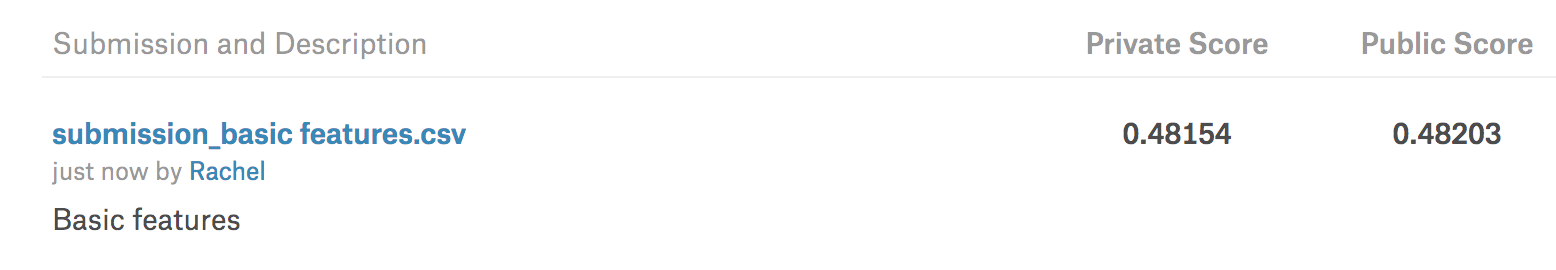

In [32]:
Image(filename = "pic/Score-basic features.png")

### 2. tfidf cosine similarity

In [13]:
df_all['all_texts'] = df_all['product_title_stemmed'] + ' . ' + df_all['product_description_stemmed'] + ' . '\
 + df_all['attribute_bullets_stemmed'] + ' . ' + df_all['product_brand'] + ' . ' + df_all['materials'] + ' . '

In [14]:
#scan all_texts calculate frequency of each word
dictionary = Dictionary(list(tokenize(x, errors='ignore')) for x in df_all['all_texts'].values)
class MyCorpus(object):
    def __iter__(self):
        for x in df_all['all_texts'].values:
            # Convert document into the bag-of-words format = list of (token_id, token_count).
            yield dictionary.doc2bow(list(tokenize(x, errors='ignore')))
corpus = MyCorpus()

#search_term & title
df_all['tfidf_cos_sim_in_title'] = df_all.apply(lambda x: \
                            calculate_tfidf_cos_sim(x['search_term_stemmed'], x['product_title_stemmed'],dictionary,corpus), axis=1)
#search_term & product_description
df_all['tfidf_cos_sim_in_desc'] = df_all.apply(lambda x: \
                            calculate_tfidf_cos_sim(x['search_term_stemmed'], x['product_description_stemmed'],dictionary,corpus), axis=1)

We used the same random forest model mentioned above to test this feature. The result shows that the cosine similarity using tfidf did not make much progress as we expected.

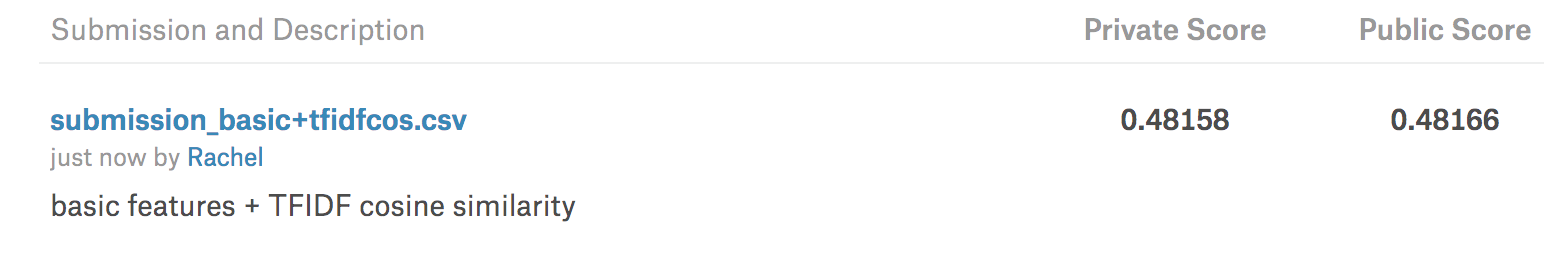

In [29]:
Image(filename = "pic/basic+tfidf.png")

### 3. word2vec
We built two different vocabularies: for processed text using two different ways of building the vocabularies (adding all parts of the available documents successively or all search terms at the first step, all product titles at the second step and so on). 
We trained two models on these vocabularies and we did not use any pretrained models. Then we calculated n similarity() between:
- stemmed search term and one of four stemmed variables (product title, product description, all attributes bullets, all text);
- stemmed product title and product description

Thus ending up with 10 word2vec features.

We built two different vocabularies: for processed text using two different ways of building the vocabularies (adding all parts of the available documents successively or all search terms at the first step, all product titles at the second step and so on). 
We trained two models on these vocabularies and we did not use any pretrained models. Then we calculated n similarity() between:
- stemmed search term and one of four stemmed variables (product title, product description, all attributes bullets, all text);
- stemmed product title and product description

Thus ending up with 10 word2vec features.

In [16]:
n_sim = get_word2vec_n_sim(df_all)
for j in range(len(n_sim)):    
    df_all["word2vec_"+str(j)]=n_sim[j]
df_all.head()

first vocab
second vocab
#####################
model vocab

n_sim  0 search_term & title

n_sim  1 search_term & description

n_sim  2 search_term & attr bullet

n_sim  3 search_term & all other texts

n_sim  4 description & title
#####################
model vocab

n_sim  5 search_term & title

n_sim  6 search_term & description

n_sim  7 search_term & attr bullet

n_sim  8 search_term & all other texts

n_sim  9 description & title
model features done


,id,product_title,product_uid,relevance,search_term,product_description,attribute_bullets,product_title_stemmed,search_term_stemmed,product_description_stemmed,...,word2vec_0,word2vec_1,word2vec_2,word2vec_3,word2vec_4,word2vec_5,word2vec_6,word2vec_7,word2vec_8,word2vec_9
0,3,simpson strong tie 12 gauge angle,100001,2.50,l bracket,angles make joints stronger also provide consi...,Versatile connector for various 90Â° connectio...,simpson strong tie 12 gaug angl,l bracket,angl make joint stronger also provid consist s...,...,-0.011469,0.144858,0.203322,0.176744,0.423917,0.291875,0.498708,0.520820,0.512093,0.692249
1,9,behr premium textured deckover 1 gal sc 141 tu...,100002,3.00,deckover,behr premium textured deckover innovative soli...,"Revives wood and composite decks, railings, po...",behr premium textur deckov 1 gal sc 141 tugboa...,deckov,behr premium textur deckov innov solid color c...,...,0.000000,0.000000,0.000000,0.000000,0.567678,0.000000,0.000000,0.000000,0.000000,0.898301
2,16,delta vero 1 handle shower faucet trim kit chrome,100005,2.33,rain shower head,update bathroom delta vero single handle showe...,"Includes the trim kit only, the rough-in kit (...",delta vero 1 handl shower faucet trim kit chrome,rain shower head,updat bathroom delta vero singl handl shower f...,...,0.314732,0.279341,0.243294,0.286336,0.516392,0.718895,0.728427,0.721911,0.733551,0.900447
3,17,delta vero 1 handle shower faucet trim kit chrome,100005,2.67,shower only faucet,update bathroom delta vero single handle showe...,"Includes the trim kit only, the rough-in kit (...",delta vero 1 handl shower faucet trim kit chrome,shower onli faucet,updat bathroom delta vero singl handl shower f...,...,0.431565,0.118983,0.061930,0.118341,0.516392,0.776568,0.733108,0.730134,0.743171,0.900447
4,18,whirlpool 1.9 cu ft. range convection microwav...,100006,3.00,convection otr,achieving delicious results almost effortless ...,Spacious 1.9 cu. ft. capacity accommodates din...,whirlpool 1.9 cu ft. rang convect microwav sta...,convect otr,achiev delici result almost effortless whirlpo...,...,0.415115,0.361885,0.364713,0.369689,0.792026,0.718786,0.703150,0.703338,0.705246,0.951706


We used the same random forest model mentioned above to test this feature.

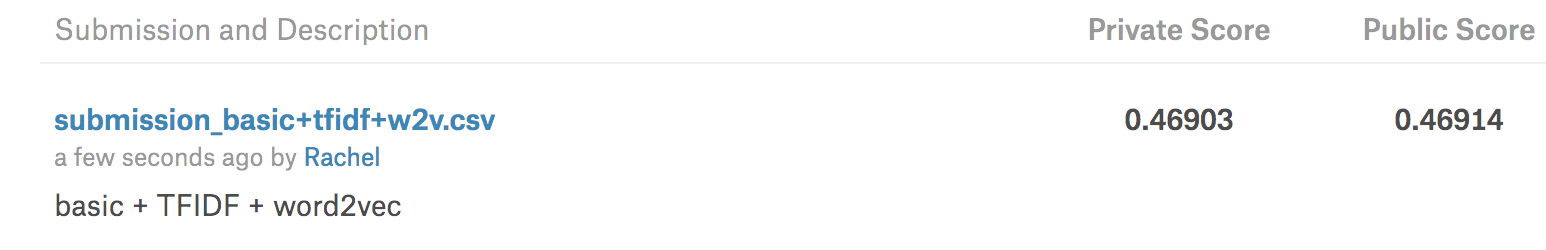

In [30]:
Image(filename = "pic/basic+tfidf+w2v.png")

### 4.  Levenshtein distance between query and title/description/attribute bullets

Levenshtein distance (LD) is a measure of the similarity between two strings, which we will refer to as the source string (s) and the target string (t). The distance is the number of deletions, insertions, or substitutions required to transform s into t. 

For example:
* If s is "test" and t is "test", then LD(s,t) = 0, because no transformations are needed. The strings are already identical.
* If s is "test" and t is "tent", then LD(s,t) = 1, because one substitution (change "s" to "n") is sufficient to transform s into t.

The greater the Levenshtein distance, the more different the strings are.

In [17]:
#search_term & title
df_all['dist_in_title'] = df_all.apply(lambda x: \
            Levenshtein.ratio(x['search_term_stemmed'],x['product_title_stemmed']), axis=1)
#search_term & product_description
df_all['dist_in_desc'] = df_all.apply(lambda x: \
            Levenshtein.ratio(x['search_term_stemmed'],x['product_description_stemmed']), axis=1)
#search_term& attribute bullet
df_all['dist_in_attr_bullet'] = df_all.apply(lambda x: \
            Levenshtein.ratio(x['search_term_stemmed'],x['attribute_bullets_stemmed']), axis=1)

We used the same random forest model mentioned above to test this feature.

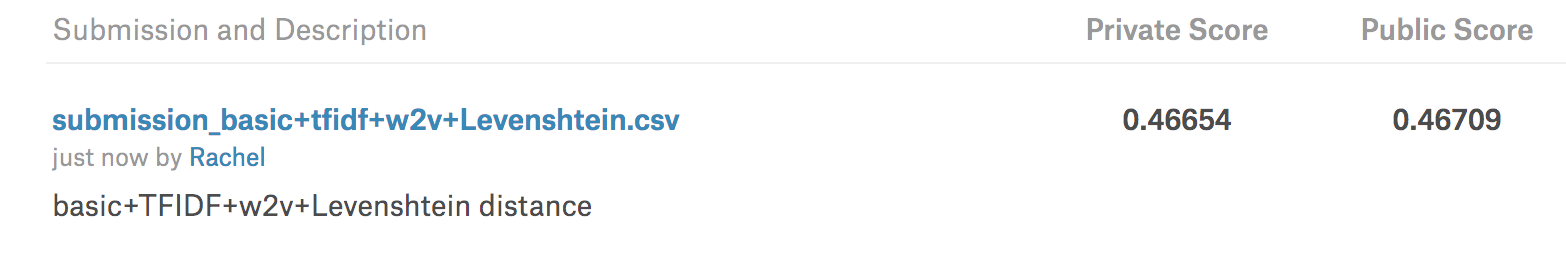

In [31]:
Image(filename = "pic/Levenshtein.png")

### 6. Some other TFIDF features

Here we calculate some basic TFIDF features by sparse matrix operations.Basically there are two kinds of features:
- the sum of inverse document frequency
- the sum of each inverse document frequency multiplied by number of letters

In [18]:
vectorizer_title =  TfidfVectorizer(stop_words='english',max_df=0.5) 
vectorizer_description =  TfidfVectorizer(stop_words='english',max_df=0.5) 
vectorizer_bullets =  TfidfVectorizer(stop_words='english',max_df=0.5) 

features_title = vectorizer_title.fit_transform(list(set(list(df_all['product_title_stemmed'])))) 
features_description = vectorizer_description.fit_transform(list(set(list(df_all['product_description_stemmed'])))) 
features_bullets = vectorizer_bullets.fit_transform(list(set(list(df_all['attribute_bullets_stemmed'])))) 

tfidf_title = vectorizer_title.transform(df_all['search_term_stemmed']) 
tfidf_description = vectorizer_description.transform(df_all['search_term_stemmed']) 
tfidf_bullets = vectorizer_bullets.transform(df_all['search_term_stemmed']) 

uno_title=np.ones((len(vectorizer_title.get_feature_names()),1))
uno_description=np.ones((len(vectorizer_description.get_feature_names()),1))
uno_bullets=np.ones((len(vectorizer_bullets.get_feature_names()),1))

In [19]:
let_title=np.asarray([[len(word)] for word in vectorizer_title.get_feature_names()])
let_description=np.asarray([[len(word)] for word in vectorizer_description.get_feature_names()])
let_bullets=np.asarray([[len(word)] for word in vectorizer_bullets.get_feature_names()])

df_all['tfidf_title_num']=tfidf_title.tocsr().dot(uno_title)
df_all['tfidf_description_num']=tfidf_description.tocsr().dot(uno_description)
df_all['tfidf_bullets_num']=tfidf_bullets.tocsr().dot(uno_bullets)

df_all['tfidf_title_let']=tfidf_title.tocsr().dot(let_title)
df_all['tfidf_description_let']=tfidf_description.tocsr().dot(let_description)
df_all['tfidf_bullets_let']=tfidf_bullets.tocsr().dot(let_bullets)


We used the same random forest model mentioned above to test this feature.

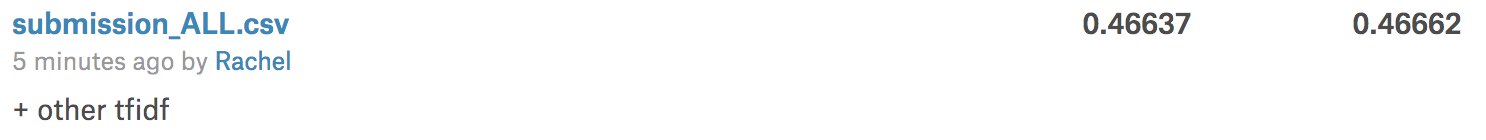

In [34]:
Image(filename='pic/other.png')

### 6. Estimate how similar strings in query and text are using SequenceMatcher

Here we used the class `difflib.SequenceMatcher`. This is a flexible class for comparing pairs of sequences of any type, so long as the sequence elements are hashable. 
The idea is to find the longest contiguous matching subsequence that contains no “junk” elements; these “junk” elements are ones that are uninteresting in some sense, such as blank lines or whitespace. This does not yield minimal edit sequences, but does tend to yield matches that “look right” to people.

We calculated the ratio and scaled ratio from difflib.SequenceMatcher() between search_term and title/bullets/sescription and also between description and attribute bullets.

In [12]:
df_all['seqmatch_title_tuple']=df_all.apply(lambda x: \
            seq_matcher(x['search_term_stemmed'],x['product_title_stemmed']),axis=1)
df_all['seqmatch_title_ratio'] = df_all['seqmatch_title_tuple'].map(lambda x: x[0])
df_all['seqmatch_title_ratioscaled'] = df_all['seqmatch_title_tuple'].map(lambda x: x[1])
df_all=df_all.drop(['seqmatch_title_tuple'],axis=1)

df_all['seqmatch_bullets_tuple']=df_all.apply(lambda x: \
            seq_matcher(x['search_term_stemmed'],x['attribute_bullets_stemmed']),axis=1)
df_all['seqmatch_bullets_ratio'] = df_all['seqmatch_bullets_tuple'].map(lambda x: x[0])
df_all['seqmatch_bullets_ratioscaled'] = df_all['seqmatch_bullets_tuple'].map(lambda x: x[1])
df_all=df_all.drop(['seqmatch_bullets_tuple'],axis=1)

df_all['seqmatch_description_tuple']=df_all.apply(lambda x: \
            seq_matcher(x['search_term_stemmed'],x['product_description_stemmed']),axis=1)
df_all['seqmatch_description_ratio'] = df_all['seqmatch_description_tuple'].map(lambda x: x[0])
df_all['seqmatch_description_ratioscaled'] = df_all['seqmatch_description_tuple'].map(lambda x: x[1])
df_all=df_all.drop(['seqmatch_description_tuple'],axis=1)

df_all['seqmatch_desc&bullets_tuple']=df_all.apply(lambda x: \
            seq_matcher(x['search_term_stemmed'],x['product_description_stemmed']+" "+x['attribute_bullets_stemmed']),axis=1)
df_all['seqmatch_desc&bullets_ratio'] = df_all['seqmatch_desc&bullets_tuple'].map(lambda x: x[0])
df_all['seqmatch_desc&bullets_ratioscaled'] = df_all['seqmatch_desc&bullets_tuple'].map(lambda x: x[1])
df_all=df_all.drop(['seqmatch_desc&bullets_tuple'],axis=1)

So here is our finalized features. Based on the original data, we extend it to total 78 columns. 

In [21]:
df_all.head()

,id,product_title,product_uid,relevance,search_term,product_description,attribute_bullets,product_title_stemmed,search_term_stemmed,product_description_stemmed,...,word2vec_9,dist_in_title,dist_in_desc,dist_in_attr_bullet,tfidf_title_num,tfidf_description_num,tfidf_bullets_num,tfidf_title_let,tfidf_description_let,tfidf_bullets_let
0,3,simpson strong tie 12 gauge angle,100001,2.50,l bracket,angles make joints stronger also provide consi...,Versatile connector for various 90Â° connectio...,simpson strong tie 12 gaug angl,l bracket,angl make joint stronger also provid consist s...,...,0.692249,0.150000,0.035874,0.041056,1.000000,1.000000,1.0,7.000000,7.000000,7.0
1,9,behr premium textured deckover 1 gal sc 141 tu...,100002,3.00,deckover,behr premium textured deckover innovative soli...,"Revives wood and composite decks, railings, po...",behr premium textur deckov 1 gal sc 141 tugboa...,deckov,behr premium textur deckov innov solid color c...,...,0.898301,0.169014,0.015444,0.018750,1.000000,1.000000,0.0,6.000000,6.000000,0.0
2,16,delta vero 1 handle shower faucet trim kit chrome,100005,2.33,rain shower head,update bathroom delta vero single handle showe...,"Includes the trim kit only, the rough-in kit (...",delta vero 1 handl shower faucet trim kit chrome,rain shower head,updat bathroom delta vero singl handl shower f...,...,0.900447,0.406250,0.066946,0.085791,1.414214,1.726831,1.0,7.071068,8.173914,4.0
3,17,delta vero 1 handle shower faucet trim kit chrome,100005,2.67,shower only faucet,update bathroom delta vero single handle showe...,"Includes the trim kit only, the rough-in kit (...",delta vero 1 handl shower faucet trim kit chrome,shower onli faucet,updat bathroom delta vero singl handl shower f...,...,0.900447,0.393939,0.075000,0.096000,1.412224,1.412224,1.0,8.473342,8.473342,4.0
4,18,whirlpool 1.9 cu ft. range convection microwav...,100006,3.00,convection otr,achieving delicious results almost effortless ...,Spacious 1.9 cu. ft. capacity accommodates din...,whirlpool 1.9 cu ft. rang convect microwav sta...,convect otr,achiev delici result almost effortless whirlpo...,...,0.951706,0.271605,0.010402,0.010228,1.000000,1.000000,1.0,7.000000,7.000000,7.0


We used the same random forest model mentioned above to test all of the feature. Here we only used the same model to test whether features helps. To further optimize the result, we will try more models and change parameters in the following section.

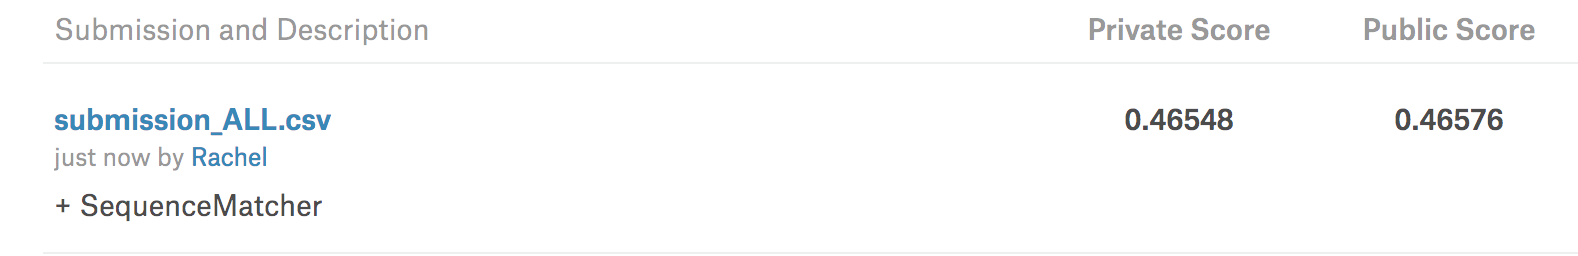

In [35]:
Image(filename='pic/seqmatch.png')

<a id = "4"></a>
# Model

In most kaggle competitions, as the goal is to rank as high as possible in the leaderboard, the interpretability of a model is not that important. Many kaggle winners are using rather complicated techniques to get better scores. Esembling/Stacking is one of the most popular techniques. The idea is that by combining information from multiple predictive models, it is likely that the new model will outperform each of the individual models due to its smoothing nature and ability to highlight each base model where it performs best and discredit each base model where it performs poorly. 

We use a 2-layer stacking model. The first layer consists of base learners, including random forest and gradient boosted tree. The second layer (meta learner) is linear regression.

In [4]:
SEED=0
numeric_features = calculable_features(df_all)
numeric_features.remove('product_uid')
test_ids, y_train, X_train, X_test = generate_train_test_data(numeric_features, df_all)

### 1. Feature Selection
The `sklean` library provides a very useful attributes `feature_importances_` after fitting a model. We use this attribute to rank features and select a heuristic number of features based on cross validation error for our base learners, random forest and gradient boosting tree. 

#### 1.1 Parameter tuning

In [5]:
# models
rf = RandomForestRegressor(random_state=SEED)
gbt = GradientBoostingRegressor(random_state=SEED)

In [6]:
base_learners = [
    ('rf', rf), ('gbt', gbt)
]
params = {
    'random_state': [0],
    'n_estimators':range(10, 150),
    'max_depth':range(3, 15)
}

In [ ]:
# Tuning base learners for feature selection
gridSearch_tuning_estimators(base_learners, params, X_train, y_train)

#### 1.2 Rank features
After first-round tuning, we get optimal parameters for both models and we use these tuned model to select features.  

`rf_param = {'max_depth':10, 'n_estimators':30}`   
`gbt_param = {'max_depth': 5, 'n_estimators': 114}`  

After ranking, we observed (the number of ranked features vs cv error plot)that the first 22 features have most influential among all features. 

In [7]:
rf_param = {'random_state':SEED,'max_depth':10, 'n_estimators':30}
gbt_param = {'random_state':SEED,'max_depth':5, 'n_estimators':114}

for model_name, model in base_learners:
    if model_name == 'rf':
        model.set_params(**rf_param)
    if model_name == 'gbt':
        model.set_params(**gbt_param)

In [8]:
feature_importances = generate_feature_importances_dataframes(base_learners, numeric_features, df_all)

In [9]:
feature_importances

,feature_rf,importances_rf,feature_gbt,importances_gbt
0,word_in_title_numratio,0.343312,word2vec_5,0.079993
1,word2vec_5,0.133125,word_in_title_letratio,0.061302
2,word2vec_0,0.044368,seqmatch_title_ratioscaled,0.057095
3,seqmatch_title_ratio,0.036394,word2vec_0,0.040912
4,word_in_description_letratio,0.035472,dist_in_title,0.037909
5,initial_len_of_query,0.035121,word2vec_8,0.036944
6,seqmatch_title_ratioscaled,0.028949,word_in_title_numratio,0.033342
7,word2vec_8,0.022256,initial_len_of_query,0.032600
8,dist_in_title,0.019520,word2vec_9,0.031296
9,word_in_title_letratio,0.017079,seqmatch_title_ratio,0.030989


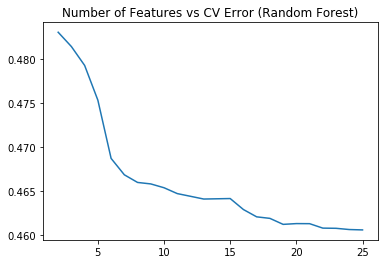

In [17]:
# Random forest
features_rf = list(feature_importances['feature_rf'])
rf_num_of_features, rf_test_scores = num_of_features_cv(rf, 25, features_rf, df_all)
%matplotlib inline
plt.plot(rf_num_of_features, rf_test_scores)
plt.title("Number of Features vs CV Error (Random Forest)")

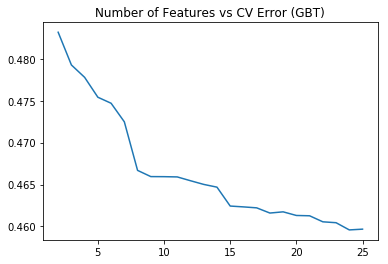

In [25]:
# Gradient Boosting Tree
features_gbt = list(feature_importances['feature_gbt'])
gbt_num_of_features, gbt_test_scores = num_of_features_cv(gbt, 25, features_gbt, df_all)
%matplotlib inline
plt.plot(gbt_num_of_features, gbt_test_scores)
plt.title("Number of Features vs CV Error (GBT)")

### 2. Parameter Tuning

We use `ml-ensemble` package to conduct parameter tuning on base learners. The advantage of using the package's parameter tuning method is that, when performing meta learners selection, we can use previously trained base learners as value of evaluator's `preprocessing` parameter instead of redoing parameter tuning.

In [10]:
features_rf = list(feature_importances['feature_rf'])
features_gbt = list(feature_importances['feature_gbt'])

In [11]:
features_rf.extend(['id', 'relevance'])
features_gbt.extend(['id', 'relevance'])

In [12]:
df_sub_rf = df_all[features_rf]
df_sub_gbt = df_all[features_gbt]

In [13]:
test_ids, rf_y_train, rf_X_train, rf_X_test = generate_train_test_data(features_rf, df_sub_rf)
test_ids, gbt_y_train, gbt_X_train, gbt_X_test = generate_train_test_data(features_gbt, df_sub_gbt)

In [14]:
# base models
rf = RandomForestRegressor(random_state=SEED)
gbt = GradientBoostingRegressor(random_state=SEED)

In [15]:
# Generate hyperparameter dictionary
base_learners = [
    ('rf', rf), ('gbt', gbt)
]
params = {
    'rf': {'max_depth': randint(3, 15),'n_estimators': randint(10, 150)},
    'gbt': {'max_depth': randint(3, 15), 'n_estimators': randint(10, 150)}
}

In [16]:
# reference: http://ml-ensemble.com/info/tutorials/start.html
# Make a scorer
mean_sqaured_error_scorer = make_scorer(mean_squared_error, greater_is_better=True)
# Run evaluation
evaluator = Evaluator(mean_sqaured_error_scorer, cv=5, random_state=SEED, verbose=1)
evaluator.fit(
                  rf_X_train, 
                  rf_y_train, 
                  estimators = base_learners,
                  param_dicts = params,
                  n_iter=3
             )

Launching job
Job           done | 00:07:25


In [17]:
pd.DataFrame(evaluator.results)

,test_score-m,test_score-s,train_score-m,train_score-s,fit_time-m,fit_time-s,pred_time-m,pred_time-s,params
gbt,0.213653,0.009005,0.206042,0.001929,75.088496,3.155117,0.199504,0.024529,"{'max_depth': 3, 'n_estimators': 127}"
rf,0.236655,0.009445,0.232111,0.001907,78.378432,0.598483,0.314881,0.025618,"{'max_depth': 3, 'n_estimators': 127}"


Using the result of grid search as a start point, we perform further parameter tuning on both estimetors. The final parameters are:  

`rf_param = {'max_depth' = 15, n_estimators=127}`  
`gbt_param = {'max_depth' = 5, n_estimators=127}`

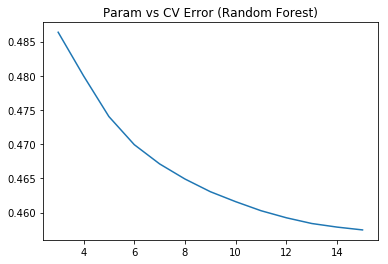

In [87]:
# Tune Max_Depth
# Random Forest
params = range(3, 16)
test_scores = []
for param in params:
    clf = RandomForestRegressor(random_state=0, max_depth=param, n_estimators=127)
    test_score = np.sqrt(-cross_val_score(clf, rf_X_train, rf_y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

%matplotlib inline
plt.plot(params, test_scores)
plt.title("Param vs CV Error (Random Forest)");

#### Single Model Result

In [21]:
# Random forest
rf_test = RandomForestRegressor(random_state=SEED, max_depth=15, n_estimators=127)
rf_test.fit(rf_X_train, rf_y_train)
p_rf = rf_test.predict(rf_X_test)
p_rf[p_rf > 3] = 3
p_rf[p_rf < 1] = 1
pd.DataFrame({"id": test_ids, "relevance": p_rf}).to_csv('submission.csv',index=False)

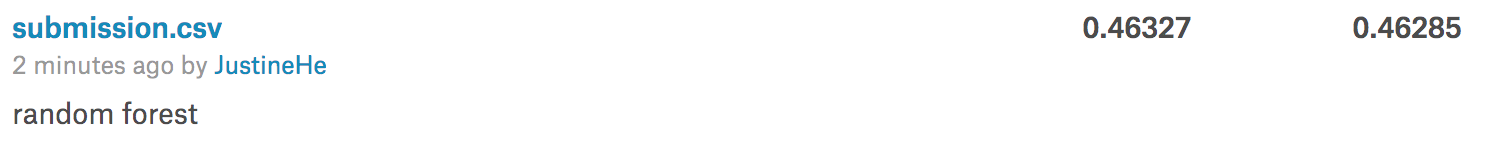

In [36]:
Image(filename='pic/rf.png')

In [20]:
# Gradient Boosting 
gbt_test = GradientBoostingRegressor(random_state=SEED, max_depth=5, n_estimators=127)
gbt_test.fit(rf_X_train, rf_y_train)
p_gbt = gbt_test.predict(rf_X_test)
p_gbt[p_gbt > 3] = 3
p_gbt[p_gbt < 1] = 1
pd.DataFrame({"id": test_ids, "relevance": p_gbt}).to_csv('submission.csv',index=False)

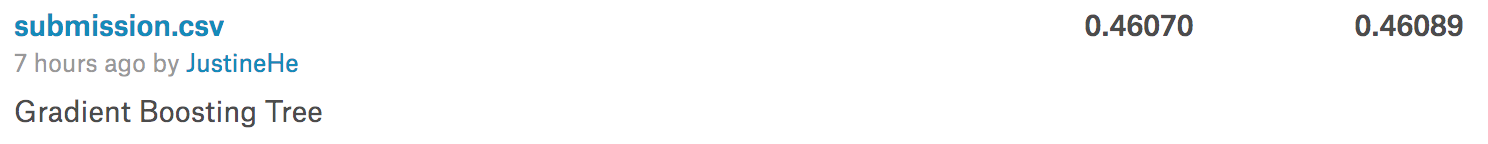

In [37]:
Image(filename='pic/gbt.png')

#### 2.3 Choose Meta Learner
We compare two meta learners, linear regression and xgboost. 

In [18]:
# Compare the performance of xgb and lr
lr = LinearRegression()
xgb_meta = XGBRegressor(random_state=SEED)
meta_learners = [
    ('xgb_meta', xgb_meta), ('lr', lr)
]
params = {
    'lr':
    {},
    'xgb_meta':
    {
     'max_depth': randint(3, 15),
     'n_estimators': randint(10, 150)
    }
}

In [19]:
# Build base learners
rf_param = {'random_state':SEED,'max_depth':15, 'n_estimators':127}
gbt_param = {'random_state':SEED,'max_depth':5, 'n_estimators':127}

for model_name, model in base_learners:
    if model_name == 'rf':
        model.set_params(**rf_param)
    if model_name == 'gbt':
        model.set_params(**gbt_param)

base_layer = SuperLearner(model_selection=True)
base_layer.add(base_learners)
preprocess = [base_layer]

In [22]:
evaluator.fit(
                rf_X_train, 
                rf_y_train,
                meta_learners,
                params,
                preprocessing={'meta': preprocess},
                n_iter=3                           
            )

Launching job
Job           done | 00:11:48


In [23]:
pd.DataFrame(evaluator.results)

,test_score-m,test_score-s,train_score-m,train_score-s,fit_time-m,fit_time-s,pred_time-m,pred_time-s,params
meta.lr,0.208448,0.009102,0.215821,0.004800,10.445641,0.449748,0.014119,0.004077,{}
meta.xgb_meta,0.210142,0.008688,0.201598,0.004491,13.412788,0.209353,0.304845,0.032817,"{'max_depth': 8, 'n_estimators': 57}"


Acoording to the result table, we can see, in our case, linear regression model outperforms xgboost. Therefore, we use linear regression as meta learner.

In [25]:
meta_learner = LinearRegression()

#### 2.4 Esemble Learning  
Now, we use trained base leaners and meta leaner to generate the prediction based on test dataset.   

The `ml-esemble` package provides an easy way to stack model. The `add` method adds learners before the last layer (meta learner) and the `add_meta` method adds the last layer of stacking.

In [26]:
stacking = SuperLearner(scorer=mean_squared_error, random_state=0, verbose=2)
stacking.add(base_learners)
stacking.add_meta(meta_learner)
stacking.fit(rf_X_train, rf_y_train)
p_stacking = stacking.predict(rf_X_test)
p_stacking[p_stacking > 3] = 3
p_stacking[p_stacking < 1] = 1
pd.DataFrame({"id": test_ids, "relevance": p_stacking}).to_csv('submission.csv',index=False)


Fitting 2 layers
Processing layer-1             done | 00:04:12
Processing layer-2             done | 00:00:00
Fit complete                        | 00:04:12

Predicting 2 layers
Processing layer-1             done | 00:00:05
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:05


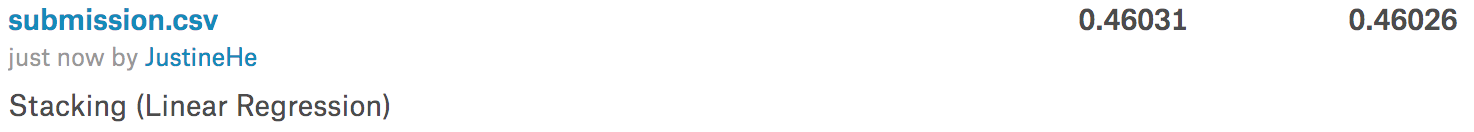

In [38]:
Image(filename='pic/stacking.png')